<a href="https://colab.research.google.com/github/Anni1808/MINed_Hackoholics/blob/main/SVM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder

# Load training and testing datasets
train_path = "/content/sample_data/final_merged_dataset.csv"
test_path = "/content/sample_data/aligned_test.csv"

df_train = pd.read_csv(train_path)
df_test = pd.read_csv(test_path)

# Remove unnamed columns
df_train = df_train.loc[:, ~df_train.columns.str.contains('^Unnamed')]
df_test = df_test.loc[:, ~df_test.columns.str.contains('^Unnamed')]

# Check for 'Type' column existence in training data
if 'Type' not in df_train.columns:
    raise KeyError("'Type' column is missing from the training dataset.")

# Separate features and target from training data
y_train = df_train["Type"]

# Identify common numeric and categorical columns for both datasets
common_columns = list(set(df_train.columns) & set(df_test.columns))
numeric_columns = [col for col in common_columns if pd.api.types.is_numeric_dtype(df_train[col])]
categorical_columns = [col for col in common_columns if pd.api.types.is_object_dtype(df_train[col])]

# Prepare features for training and testing datasets
X_train = df_train[numeric_columns + categorical_columns]
X_test = df_test[numeric_columns + categorical_columns]

# Create preprocessor for handling mixed data types
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_columns),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_columns)
    ])

# Prepare data
X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)

# Split the training data into training and validation subsets
X_train_split, X_val_split, y_train_split, y_val_split = train_test_split(
    X_train_processed, y_train, test_size=0.2, random_state=42, stratify=y_train
)

# Hyperparameter tuning using GridSearchCV
param_grid = {
    'C': [0.1, 1, 10],
    'gamma': ['scale', 'auto'],
    'kernel': ['rbf', 'linear']
}
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

grid_search = GridSearchCV(SVC(), param_grid, cv=kfold, scoring='accuracy', verbose=1, n_jobs=-1)
grid_search.fit(X_train_split, y_train_split)

# Best model
best_svm = grid_search.best_estimator_
print("Best Parameters:", grid_search.best_params_)

# Evaluate the model on the validation subset
y_val_pred = best_svm.predict(X_val_split)

# Calculate performance metrics on the validation subset
accuracy = accuracy_score(y_val_split, y_val_pred)
precision = precision_score(y_val_split, y_val_pred, average='macro')
recall = recall_score(y_val_split, y_val_pred, average='macro')
f1 = f1_score(y_val_split, y_val_pred, average='macro')
conf_matrix = confusion_matrix(y_val_split, y_val_pred)

# Print results
print("\nValidation Set Performance Metrics:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print("Confusion Matrix:\n", conf_matrix)

# Prediction on test dataset (without true labels)
y_pred = best_svm.predict(X_test_processed)

# Save predictions along with SHA256 hashes to a CSV file
predictions_df = pd.DataFrame({
    'SHA256': df_test['SHA256'],  # Assuming SHA256 is present in the test data
    'Predictions': y_pred  # Predicted labels from the model
})

predictions_df.to_csv('predictions_malware.csv', index=False)

print("\nPredictions saved to predictions_malware.csv")

Fitting 5 folds for each of 12 candidates, totalling 60 fits
Best Parameters: {'C': 1, 'gamma': 'scale', 'kernel': 'linear'}

Validation Set Performance Metrics:
Accuracy: 0.9752
Precision: 0.9797
Recall: 0.9786
F1 Score: 0.9786
Confusion Matrix:
 [[40  0  0  0  0  0  0]
 [ 3 37  0  0  0  0  0]
 [ 1  2 37  0  0  0  0]
 [ 0  0  0 40  0  0  0]
 [ 0  0  0  0 40  0  0]
 [ 0  0  0  0  0  2  0]
 [ 0  0  0  0  0  0 40]]

Predictions saved to predictions_malware.csv


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:3001: UserWarning: The y_pred values do not sum to one. Make sure to pass probabilities.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:3001: UserWarning: The y_pred values do not sum to one. Make sure to pass probabilities.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:3001: UserWarning: The y_pred values do not sum to one. Make sure to pass probabilities.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:3001: UserWarning: The y_pred values do not sum to one. Make sure to pass probabilities.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:3001: UserWarning: The y_pred values do not sum to one. Make sure to pass probabilities.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:3001: UserWarning: T

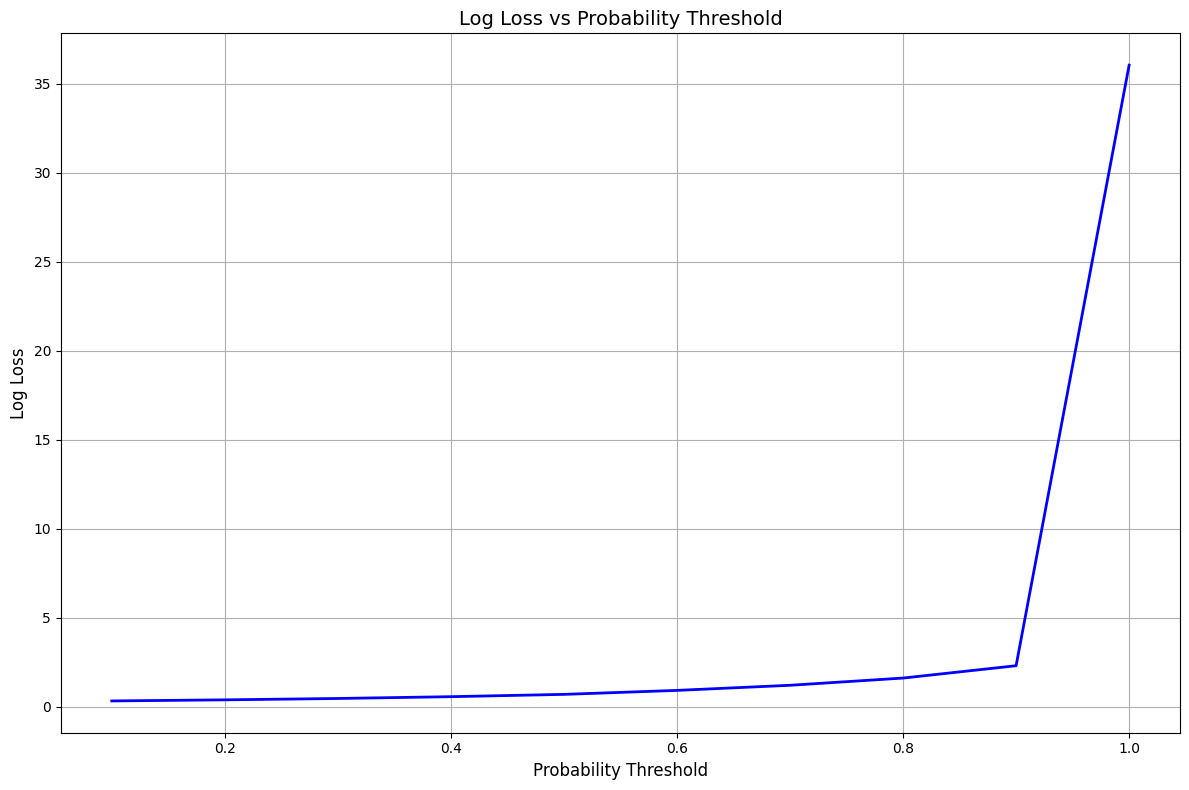

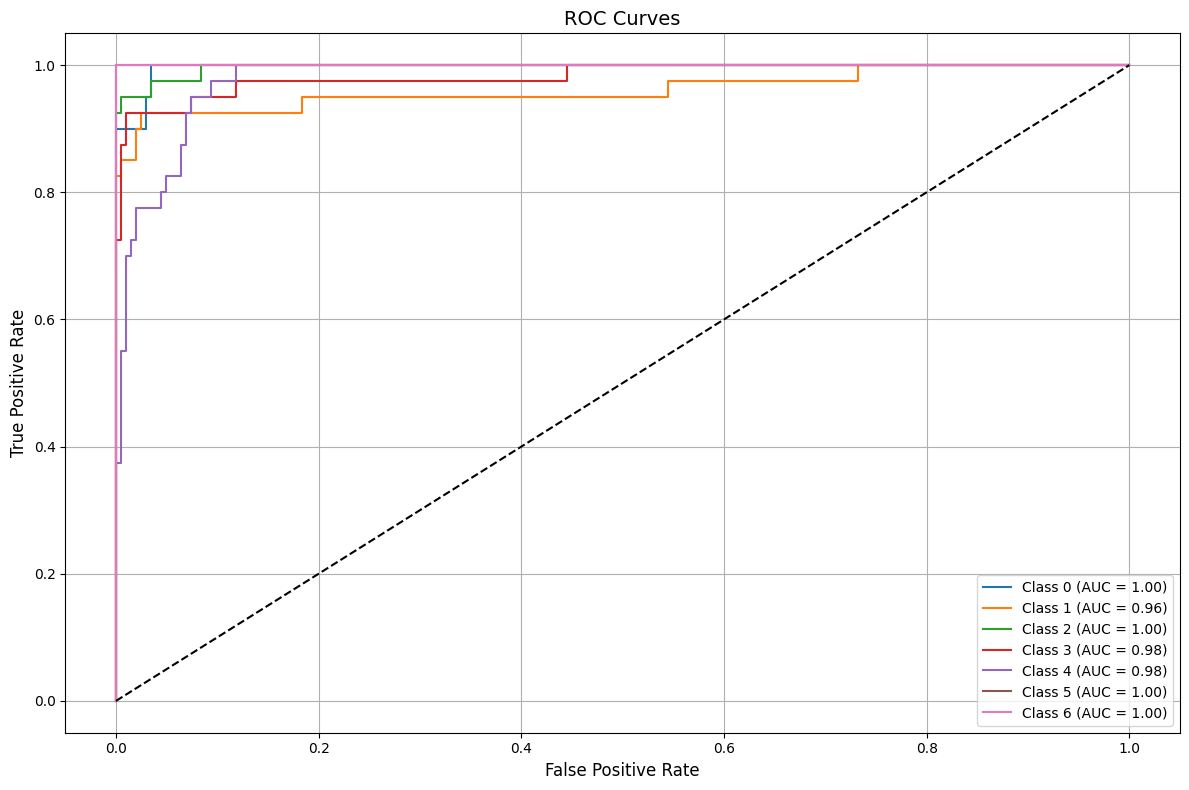

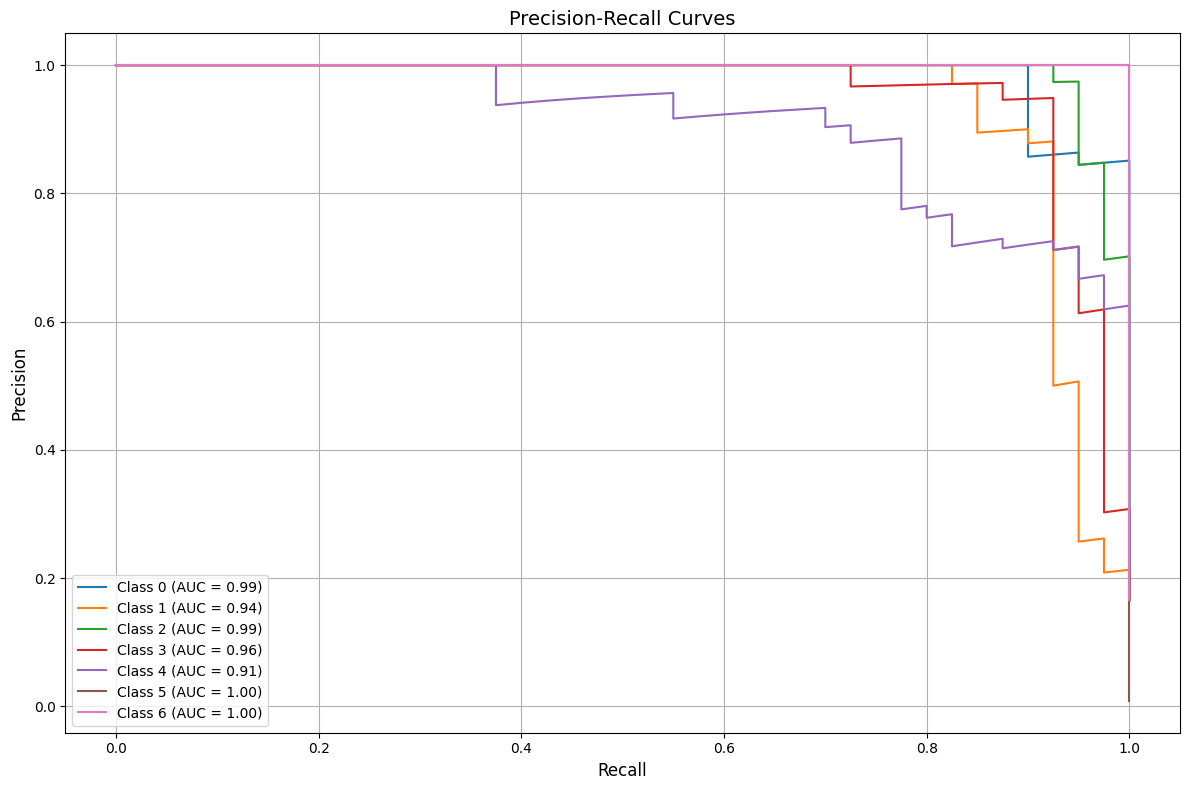

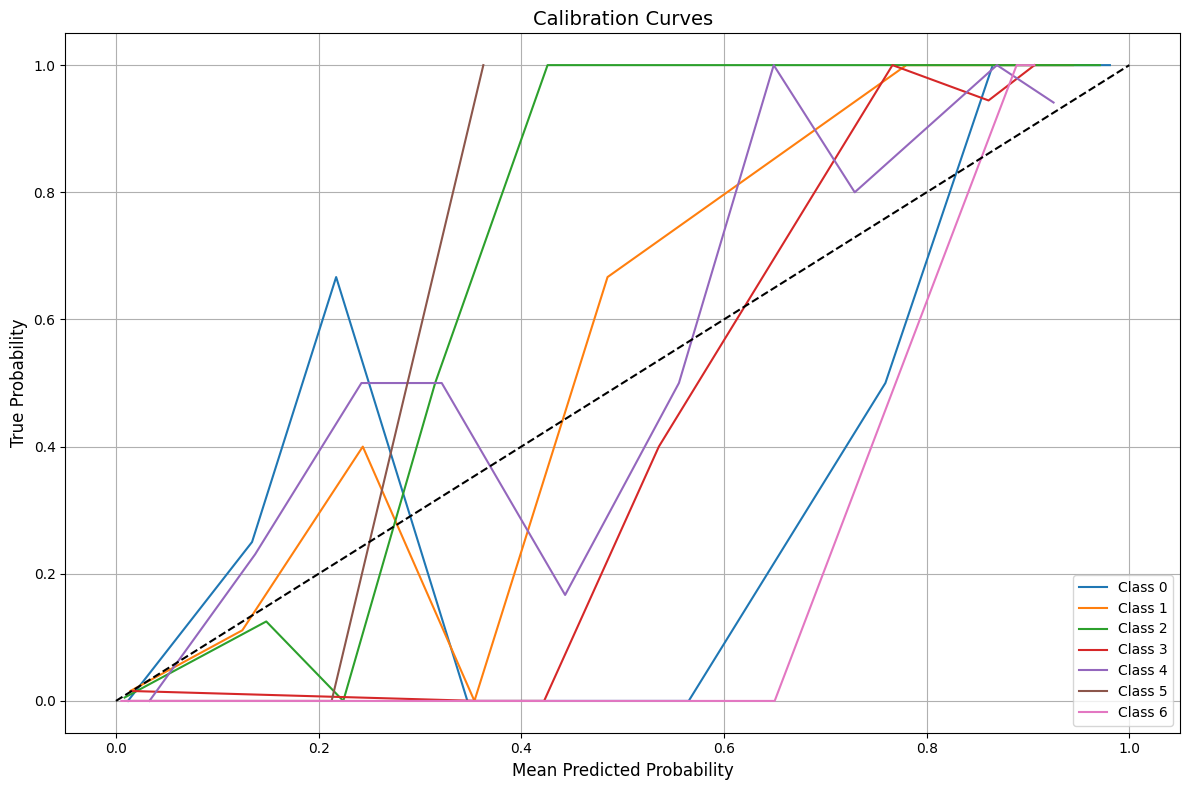

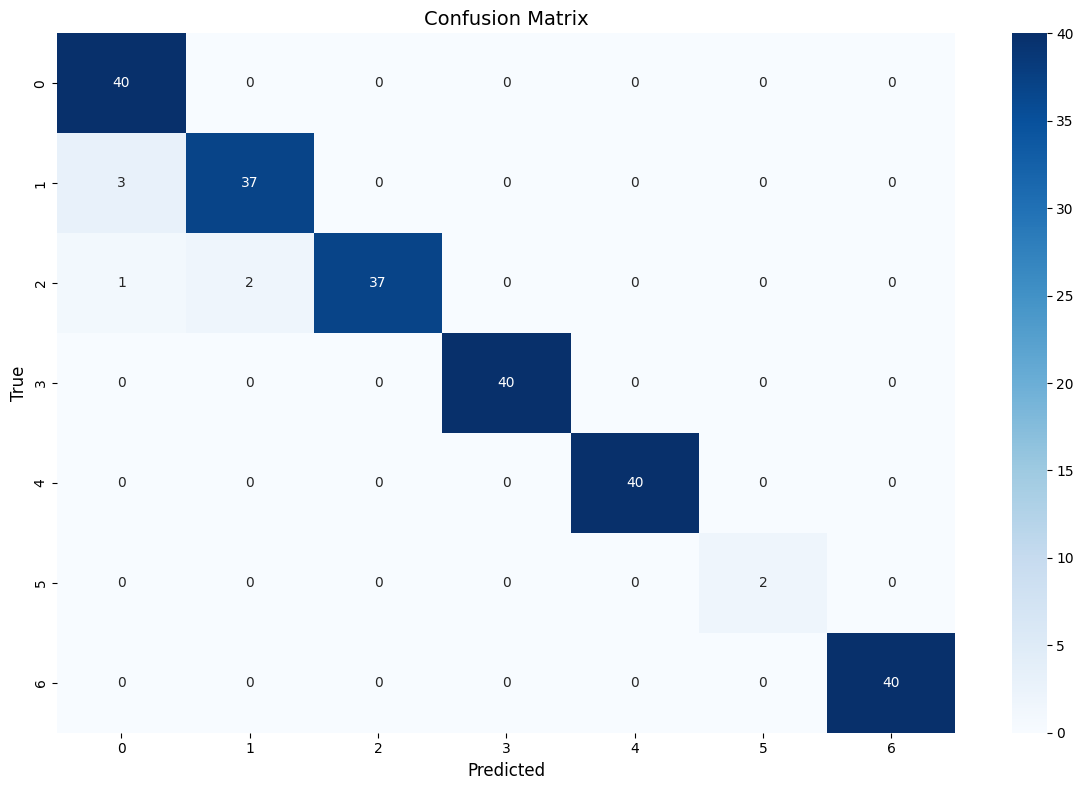


Detailed Performance Metrics:
ROC AUC Scores:
Class 0: 0.9968
Class 1: 0.9618
Class 2: 0.9969
Class 3: 0.9828
Class 4: 0.9801
Class 5: 1.0000
Class 6: 1.0000

PR AUC Scores:
Class 0: 0.9854
Class 1: 0.9405
Class 2: 0.9880
Class 3: 0.9587
Class 4: 0.9074
Class 5: 1.0000
Class 6: 1.0000


In [11]:
# First install seaborn if not already installed
!pip install seaborn

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve, auc, precision_recall_curve, log_loss
from sklearn.calibration import calibration_curve
from sklearn.preprocessing import label_binarize
import numpy as np

# Set figure size for all plots
plt.style.use('default')
fig_size = (12, 8)

# 1. Log Loss Plot
plt.figure(figsize=fig_size)
thresholds = np.linspace(0.1, 1.0, 10)
log_losses = []
for threshold in thresholds:
    prob_threshold = np.clip(y_val_proba, threshold, 1-threshold)
    loss = log_loss(y_val_split, prob_threshold)
    log_losses.append(loss)

plt.plot(thresholds, log_losses, 'b-', lw=2)
plt.xlabel('Probability Threshold', fontsize=12)
plt.ylabel('Log Loss', fontsize=12)
plt.title('Log Loss vs Probability Threshold', fontsize=14)
plt.grid(True)
plt.tight_layout()
plt.show()

# 2. ROC Curve
plt.figure(figsize=fig_size)
classes = best_svm.classes_
y_val_bin = label_binarize(y_val_split, classes=classes)
n_classes = y_val_bin.shape[1]

fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_val_bin[:, i], y_val_proba[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    plt.plot(fpr[i], tpr[i], label=f'Class {classes[i]} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curves', fontsize=14)
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.show()

# 3. Precision-Recall Curve
plt.figure(figsize=fig_size)
precision = dict()
recall = dict()
pr_auc = dict()

for i in range(n_classes):
    precision[i], recall[i], _ = precision_recall_curve(y_val_bin[:, i], y_val_proba[:, i])
    pr_auc[i] = auc(recall[i], precision[i])
    plt.plot(recall[i], precision[i], label=f'Class {classes[i]} (AUC = {pr_auc[i]:.2f})')

plt.xlabel('Recall', fontsize=12)
plt.ylabel('Precision', fontsize=12)
plt.title('Precision-Recall Curves', fontsize=14)
plt.legend(loc='lower left')
plt.grid(True)
plt.tight_layout()
plt.show()

# 4. Calibration Curve
plt.figure(figsize=fig_size)
for i in range(n_classes):
    prob_true, prob_pred = calibration_curve(y_val_bin[:, i], y_val_proba[:, i], n_bins=10)
    plt.plot(prob_pred, prob_true, label=f'Class {classes[i]}')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('Mean Predicted Probability', fontsize=12)
plt.ylabel('True Probability', fontsize=12)
plt.title('Calibration Curves', fontsize=14)
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.show()

# 5. Confusion Matrix
plt.figure(figsize=fig_size)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted', fontsize=12)
plt.ylabel('True', fontsize=12)
plt.title('Confusion Matrix', fontsize=14)
plt.tight_layout()
plt.show()

# Print numerical metrics
print("\nDetailed Performance Metrics:")
print(f"ROC AUC Scores:")
for i in range(n_classes):
    print(f"Class {classes[i]}: {roc_auc[i]:.4f}")

print("\nPR AUC Scores:")
for i in range(n_classes):
    print(f"Class {classes[i]}: {pr_auc[i]:.4f}")